In [1]:
#main imports
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import acquire
import os
import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
import statsmodels.api as sm

#partial imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, f_regression, SelectKBest

#custom imports
import acquire
import prepare


In [3]:
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [4]:
url = "https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv"
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00
Shape: (45252, 1)


,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
2012-10-01 18:00:00,61.327473
2012-10-01 19:00:00,61.390200
2012-10-01 20:00:00,61.452926
2012-10-01 21:00:00,61.515652


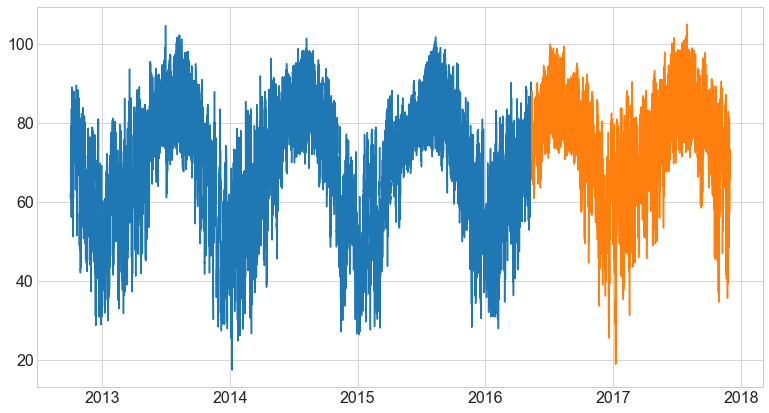

In [5]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

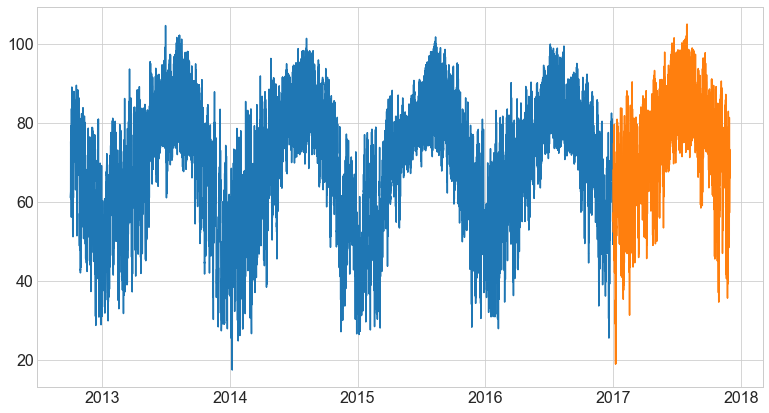

In [8]:
train = df.loc[:'2016'] # includes 2016
test = df.loc['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

In [14]:
train.head()

,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747


In [9]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

Text(0.5, 1.0, 'Distribution of Temp')

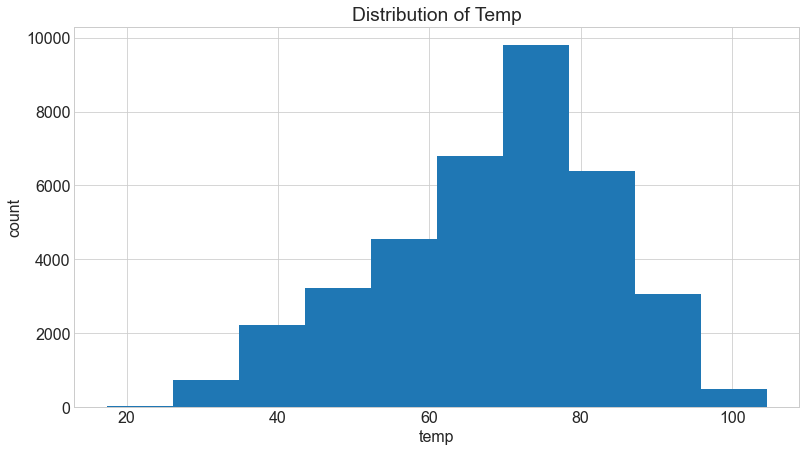

In [13]:
y.plot.hist()
plt.xlabel("temp")
plt.ylabel("count")
plt.title("Distribution of Temp")

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

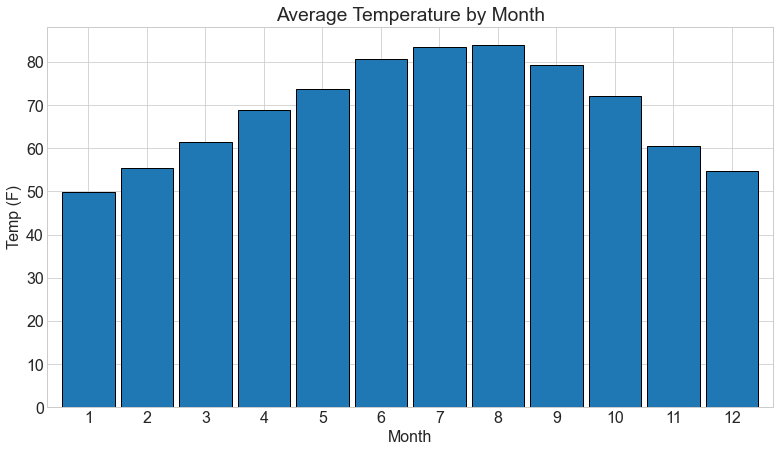

In [15]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')

[Text(0.5, 1.0, 'Average Temperature by Week'),
 Text(0.5, 0, 'Week'),
 Text(0, 0.5, 'Temp (F)')]

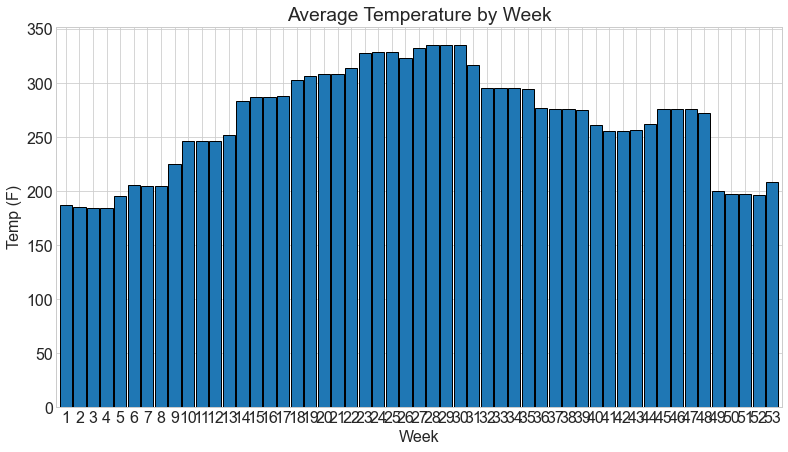

In [119]:
ax = y_train.groupby(y_train.index.isocalendar().week).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Week', xlabel='Week', ylabel='Temp (F)')

[Text(0.5, 1.0, 'Average Temperature by Weekday'),
 Text(0.5, 22.200000000000003, 'Weekday'),
 Text(22.200000000000003, 0.5, 'Temp (F)')]

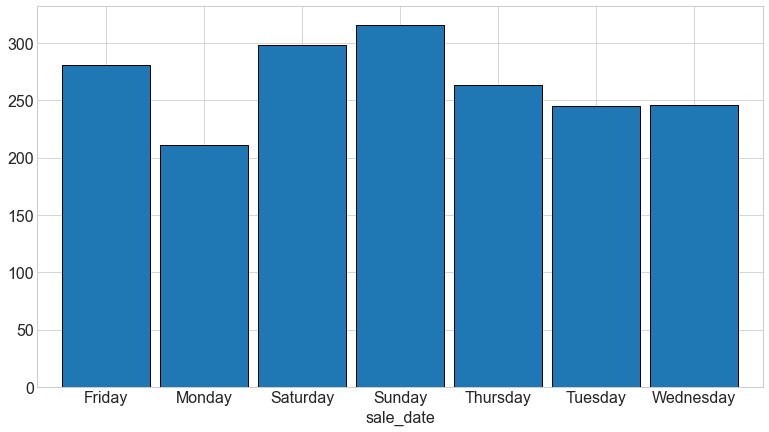

In [120]:
y_train.groupby(y_train.index.day_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Weekday', xlabel='Weekday', ylabel='Temp (F)')


<AxesSubplot:xlabel='datetime'>

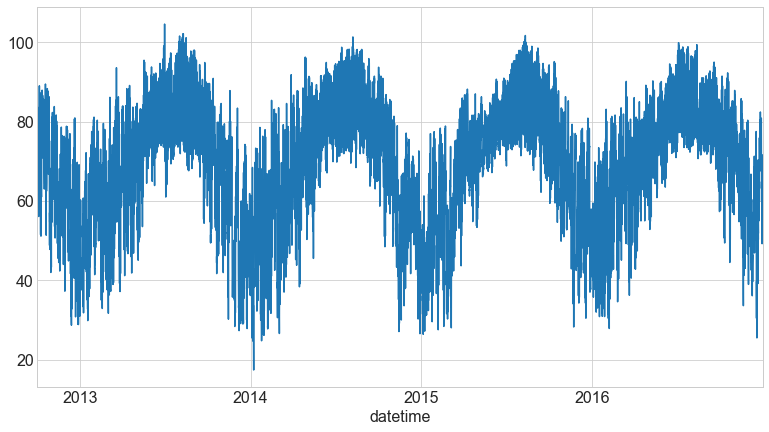

In [23]:
y.plot()

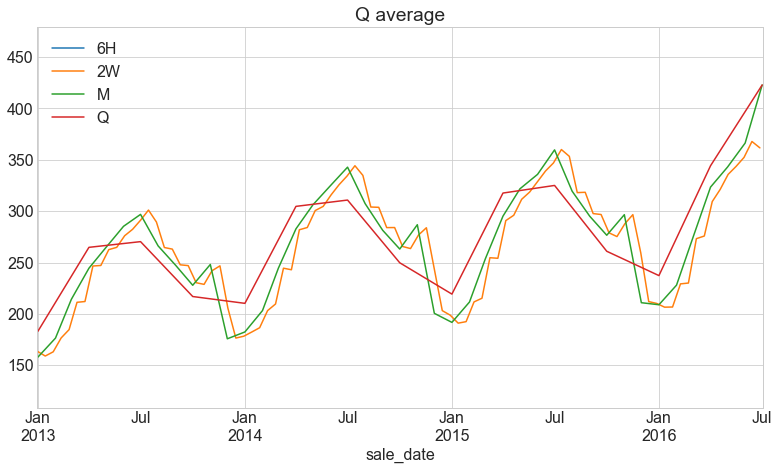

In [121]:
for i in ["6H","2W","M","Q"]:
    y_train.resample(i).mean().plot(title=f'{i} average',label=i)
plt.legend()
plt.show()

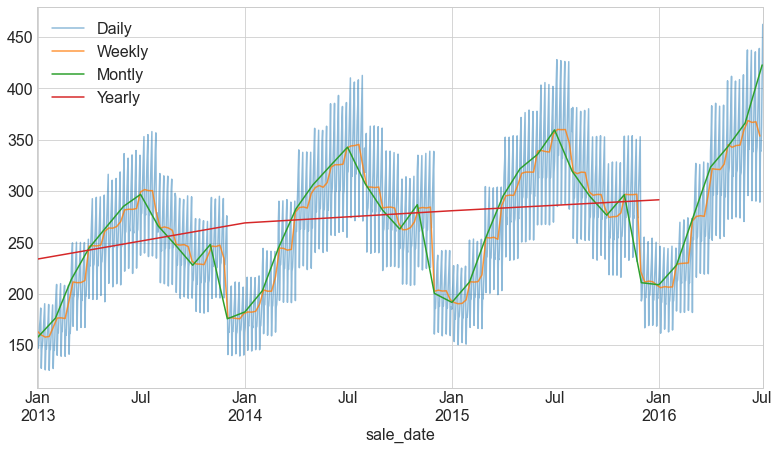

In [123]:
y_train.resample('D').mean().plot(alpha=.5, label='Daily')
y_train.resample('W').mean().plot(alpha=.8, label='Weekly')
y_train.resample('M').mean().plot(label='Montly')
y_train.resample('Y').mean().plot(label='Yearly')
plt.legend()

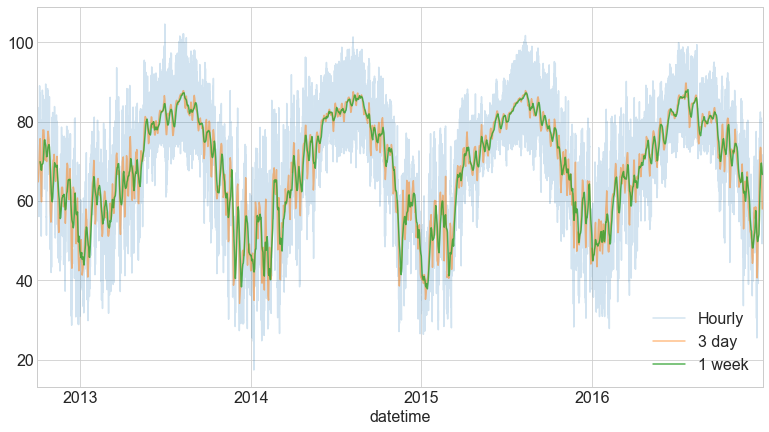

In [30]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=.8, label='1 week')
plt.legend()

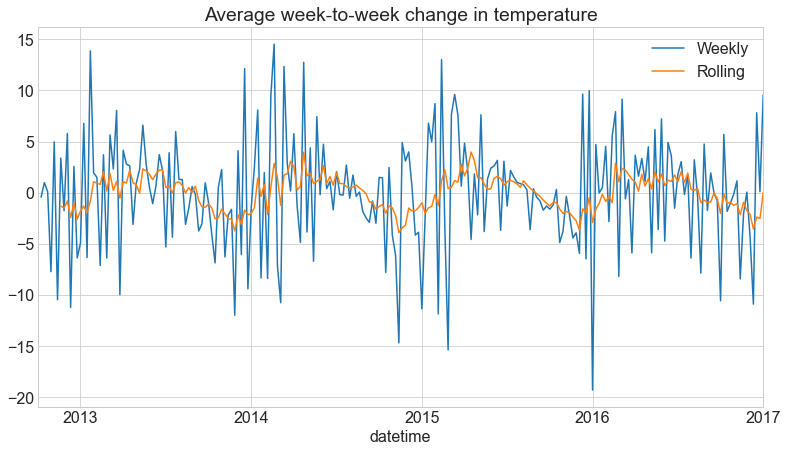

In [39]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature',label="Weekly")
y.resample('W').mean().rolling(7).mean().diff().plot(title='Average week-to-week change in temperature',label="Rolling")
plt.legend()

<AxesSubplot:title={'center':'Average month-to-month change in temperature'}, xlabel='datetime'>

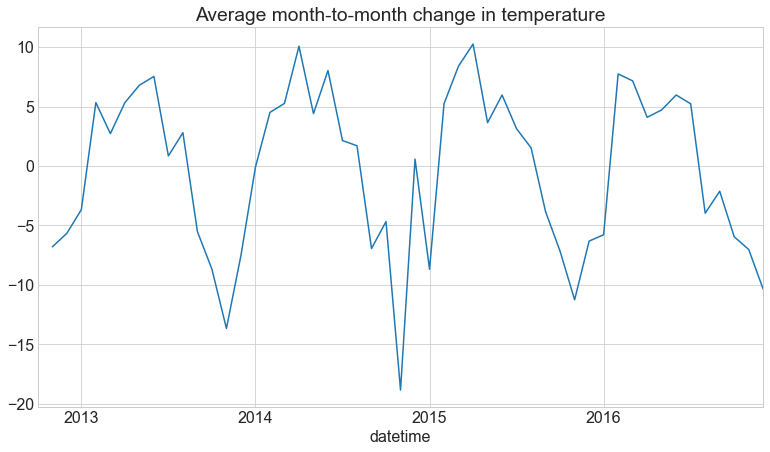

In [40]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')


In [46]:
y.groupby([y.index.year, y.index.month]).mean().head()

datetime  datetime
2012      10          69.318705
          11          62.521575
          12          56.860014
2013      1           53.192333
          2           58.522799
Name: temp, dtype: float64

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='datetime'>

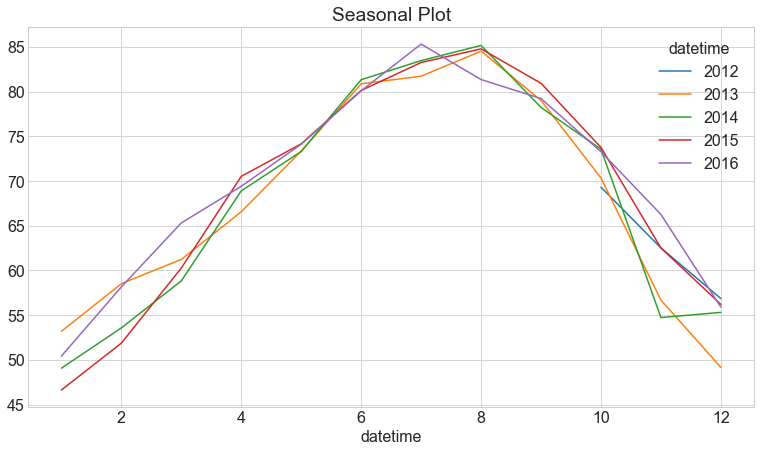

In [48]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')


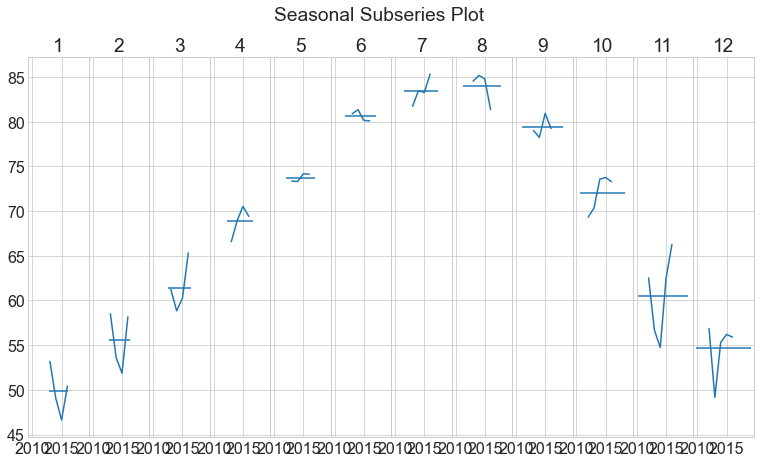

In [50]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)


#Here each subplot column represents one month, 
# and within the each subplot we see how the average temperature 
# for that month has changed from year to year. 
# The dashed black line across the middle of each subplot represents 
# the average temperature for that month.

Text(0.5, 1.0, 'Lag plot with lag=1')

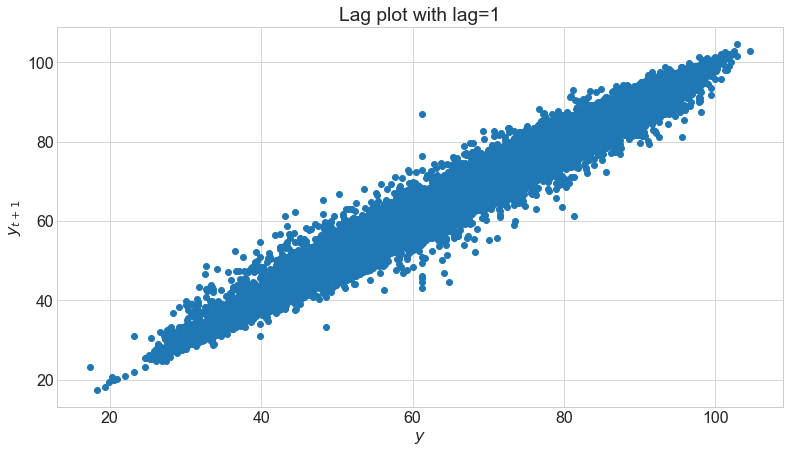

In [51]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')


/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_25668/3662136212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y(t + 1)'] = train.temp.shift(-1)


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

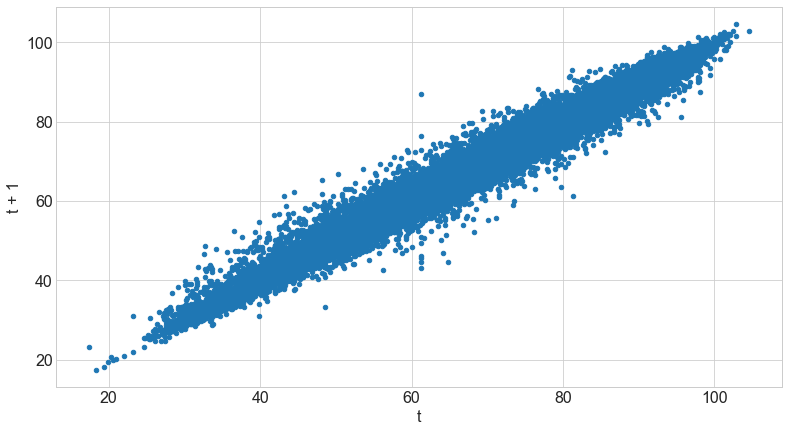

In [52]:
train['y(t + 1)'] = train.temp.shift(-1)
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')


In [53]:
del train['y(t + 1)']

,this_week,the_next_week
datetime,,
2012-10-07,70.595201,70.152821
2012-10-14,70.152821,71.138375
2012-10-21,71.138375,71.230464
2012-10-28,71.230464,63.510554
2012-11-04,63.510554,68.482625
...,...,...
2016-12-04,59.062094,48.163625
2016-12-11,48.163625,55.979132
2016-12-18,55.979132,56.073143


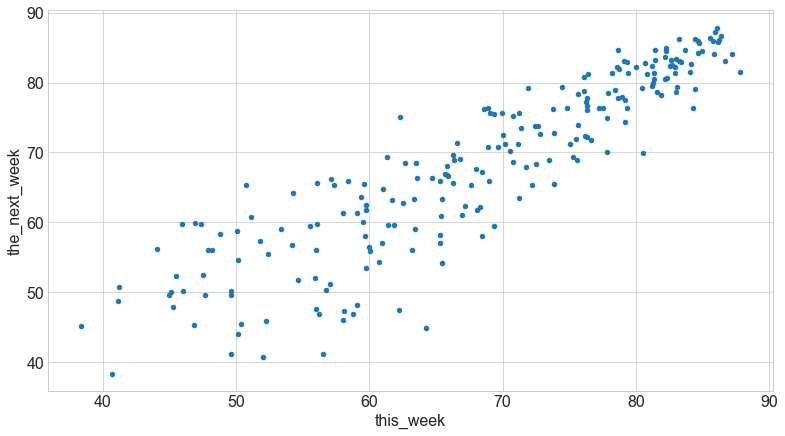

In [54]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly


,this_week,12_weeks_out
datetime,,
2012-10-07,70.595201,50.376741
2012-10-14,70.152821,45.473616
2012-10-21,71.138375,52.252877
2012-10-28,71.230464,45.907936
2012-11-04,63.510554,59.763739
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


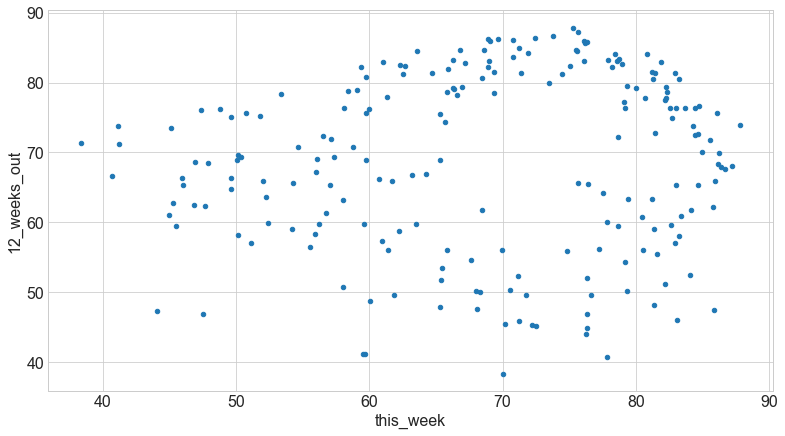

In [55]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly


,this_week,half_a_year_later
datetime,,
2012-10-07,70.595201,63.558611
2012-10-14,70.152821,66.345532
2012-10-21,71.138375,68.965502
2012-10-28,71.230464,65.862071
2012-11-04,63.510554,66.797107
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


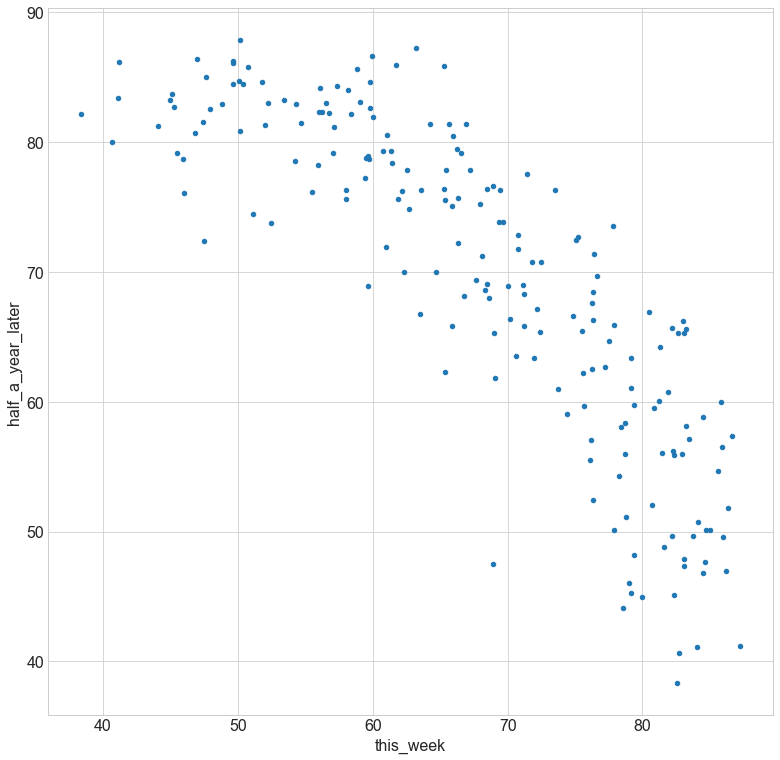

In [56]:
weekly = train.resample('W').mean()
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

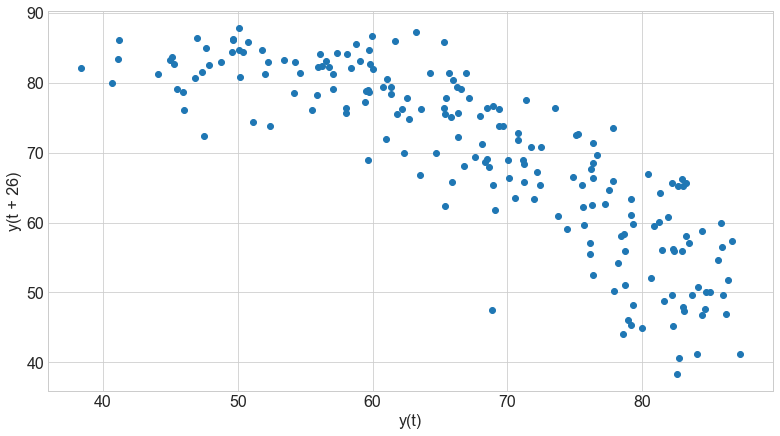

In [57]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

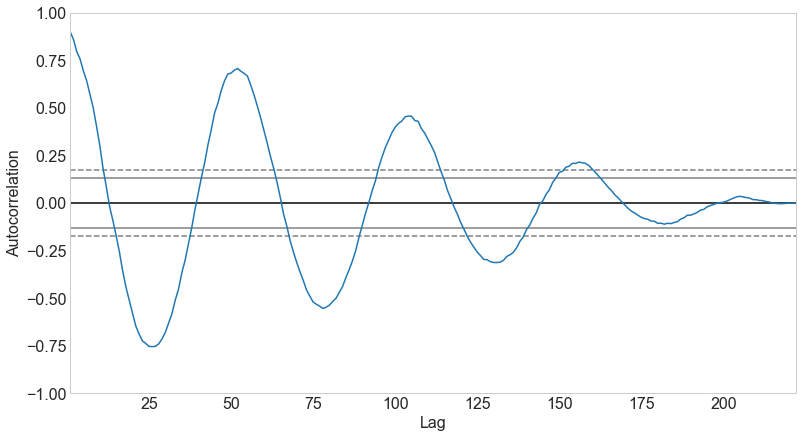

In [58]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())


Seasonal decomposition is a fancy way to say that we can model time series as having 3 seperate components, the seasonal repeated cycle, the long term trend, and random noise1.   

There are two types of seasonal decomposition models, additive and multiplicative. 


Additive seasonal decomposition model:
yt=St+Tt+Rt

Multiplicative model:
yt=St×Tt×Rt

We can use the seasonal_decompose function from the statsmodels library to perform this decomposition.

In [59]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()


,y,trend,seasonal,resid
datetime,,,,
2012-10-07,70.595201,NaN,8.545501,NaN
2012-10-14,70.152821,NaN,7.255470,NaN
2012-10-21,71.138375,NaN,2.468309,NaN
2012-10-28,71.230464,NaN,1.820126,NaN
2012-11-04,63.510554,NaN,-0.114287,NaN


<AxesSubplot:xlabel='datetime'>

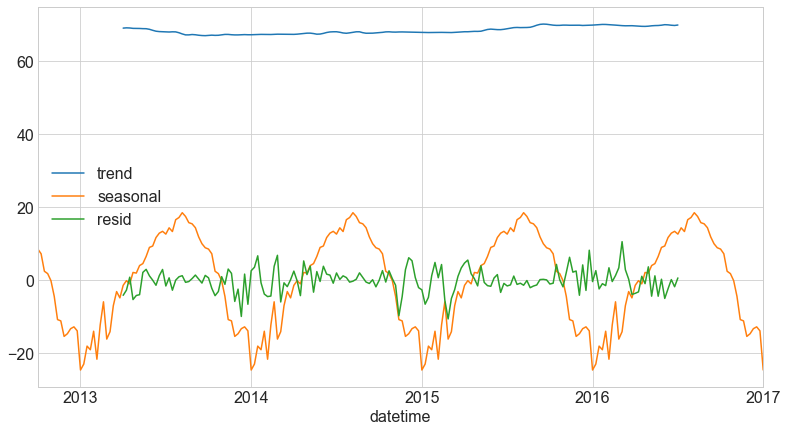

In [60]:
decomposition.iloc[:, 1:].plot()

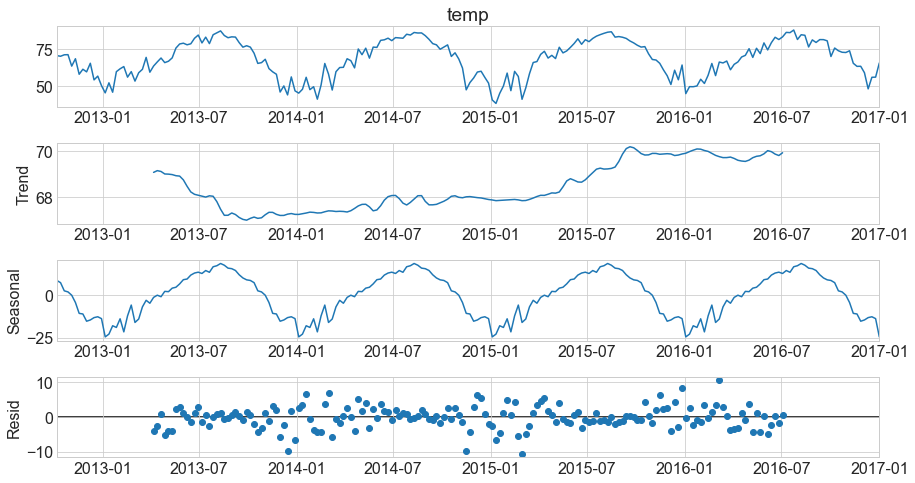

In [61]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

In [62]:
train = train.resample('D').mean()
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,49.381699
cool,65.200219
warm,75.447977
hot,83.449087


In [66]:
train.groupby('temp_bin').resample('M').size().unstack(0)

temp_bin,cold,cool,warm,hot
datetime,,,,
2012-10-31,6.0,9.0,16.0,NaN
2012-11-30,10.0,16.0,4.0,NaN
2012-12-31,16.0,14.0,1.0,NaN
2013-01-31,24.0,5.0,2.0,NaN
2013-02-28,17.0,11.0,0.0,NaN
2013-03-31,11.0,16.0,4.0,NaN
2013-04-30,7.0,14.0,9.0,NaN
2013-05-31,1.0,8.0,16.0,6.0
2013-06-30,0.0,0.0,12.0,18.0


Text(0, 0.5, '% of days in the month')

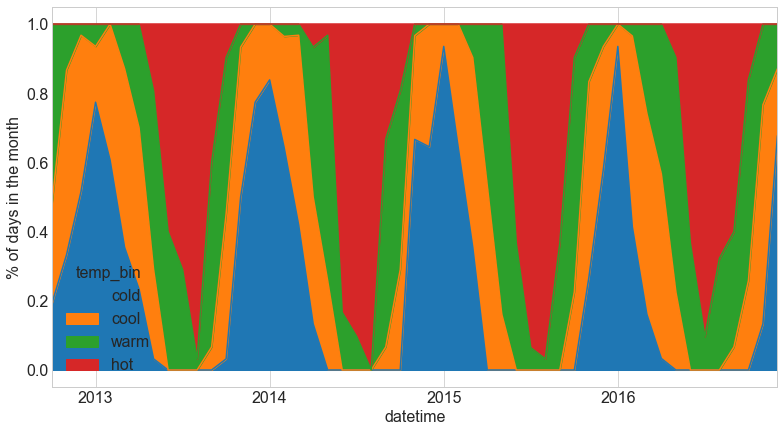

In [63]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_25668/166317864.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = (train['2015']


[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

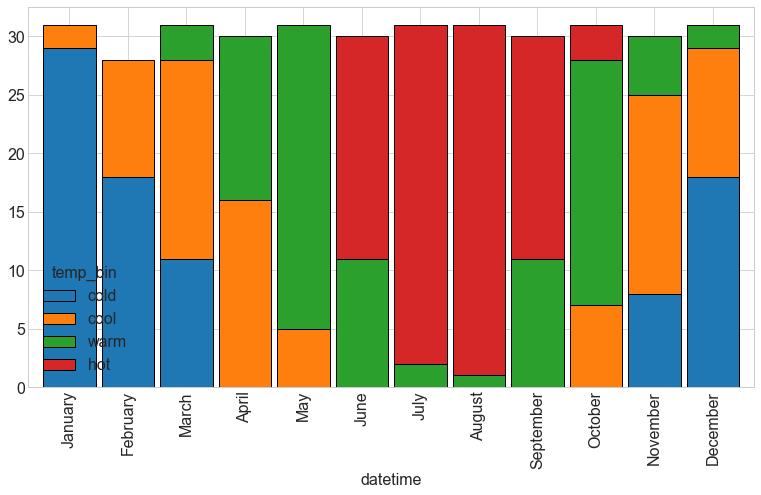

In [67]:
ax = (train['2015'].groupby('temp_bin').resample('M').\
    size().unstack(0).plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)


In [68]:
train.head()

,temp,temp_bin
datetime,,
2012-10-01,61.330942,cool
2012-10-02,65.678822,cool
2012-10-03,67.411250,cool
2012-10-04,67.703750,cool
2012-10-05,77.073125,warm


/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_25668/536148800.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = (train['2015']


[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

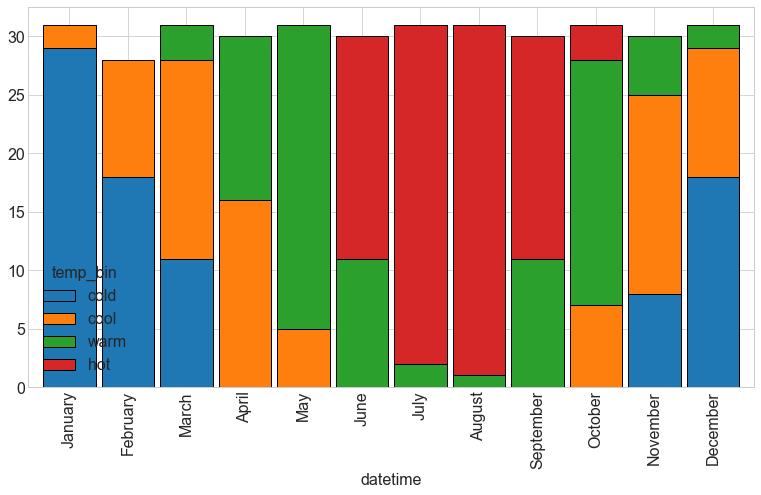

In [69]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

A common problem we can run into when visualizing time series data is that the order of the months or days of the week logically is not the same as the order alphabetically. One workaround for this is to format the dates such that the have a number prepended to them (for example, 0-sunday, 1-monday) and the plot. Once the plot is created, we can manipulate the tick labels and remove the prefix.

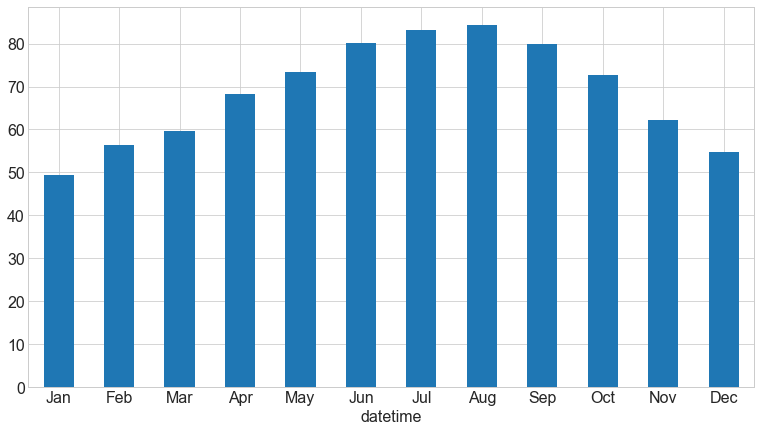

In [73]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

If you wish to apply custom formatting to your axes, you should use plt.plot or ax.plot and pass the datetime index as your x values as opposed to using the built-in pandas plotting methods.

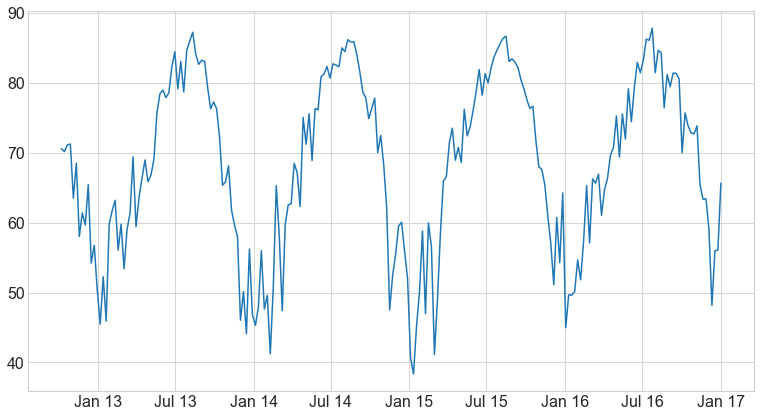

In [74]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))


# Do your work for this exercise in a notebook named explore. 
# Use the techniques in the lesson to explore the store item demand dataset and the opsd dataset.

# For the store item demand data, you will need to choose a method of aggregating such that each observation is a unique date. 
# For both datasets you should choose a method of splitting your data and only explore the training split.

is null before
 Consumption       0
Wind           1463
Solar          2195
Wind+Solar     2196
month             0
year              0
dtype: int64
is null after
 Consumption    0
Wind           0
Solar          0
Wind+Solar     0
month          0
year           0
dtype: int64


,Consumption,Wind,Solar,Wind+Solar,month,year
Date,,,,,,
2006-01-01,1069.18400,0.000,0.000,0.000,January,2006
2006-01-02,1380.52100,0.000,0.000,0.000,January,2006
2006-01-03,1442.53300,0.000,0.000,0.000,January,2006
2006-01-04,1457.21700,0.000,0.000,0.000,January,2006
2006-01-05,1477.13100,0.000,0.000,0.000,January,2006
...,...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037,December,2017
2017-12-28,1299.86398,506.424,14.162,520.586,December,2017
2017-12-29,1295.08753,584.277,29.854,614.131,December,2017


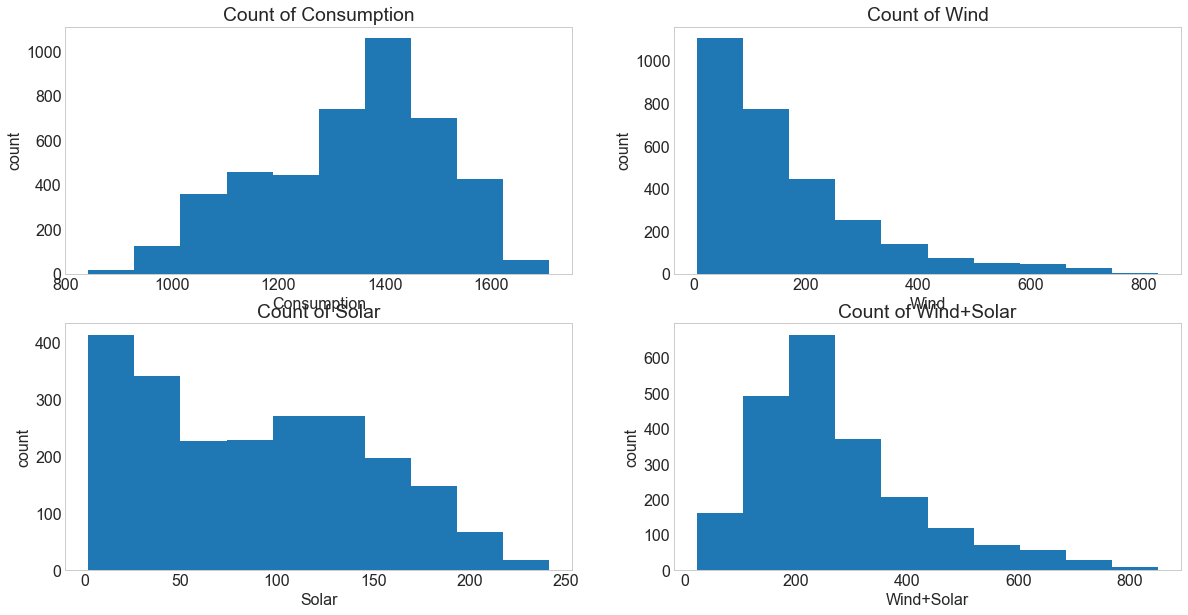

In [157]:
df1 = prepare.prep_germany_opsd()
target1 = "Consumption"
df1

store ids = [ 1  2  3  4  5  6  7  8  9 10] | store cities = ['San Antonio'] | store states = ['TX']
sale amount count = 213 | sale date count = 1826
item brand count = 49 | item name count = 50 | item_price count = 47


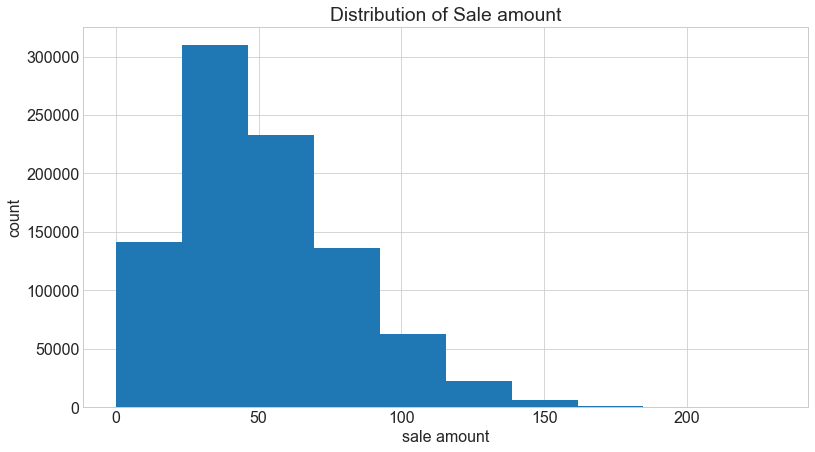

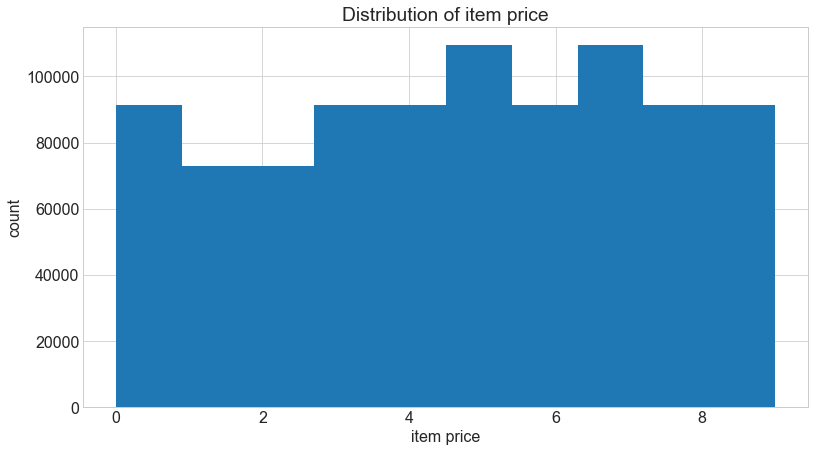

,sale_amount,store,store_address,store_city,store_state,store_zipcode,item_brand,item_name,item_price,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,
2013-01-01,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Riceland,Riceland American Jazmine Rice,0.84,January,Tuesday,10.92
2013-01-01,26.0,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,January,Tuesday,218.40
2013-01-01,27.0,7,12018 Perrin Beitel Rd,San Antonio,TX,78217,Mama Marys,Pizza Sauce,4.65,January,Tuesday,125.55
2013-01-01,54.0,8,15000 San Pedro Ave,San Antonio,TX,78232,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,January,Tuesday,453.60
2013-01-01,35.0,9,735 SW Military Dr,San Antonio,TX,78221,Mueller,Mueller Sport Care Basic Support Level Medium ...,8.40,January,Tuesday,294.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,21.0,9,735 SW Military Dr,San Antonio,TX,78221,Halls,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,December,Sunday,87.57
2017-12-31,32.0,10,8503 NW Military Hwy,San Antonio,TX,78231,Halls,Halls Menthol Cough Suppresant/oral Anesthetic...,4.17,December,Sunday,133.44
2017-12-31,55.0,1,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,Natures Way,Natures Way Forskohlii - 60 Ct,5.19,December,Sunday,285.45


In [158]:
df0 = prepare.prep_sales()
target0 = "sales_total"
df0

In [173]:
def explore_split_time_series(df,target="",train_size=.7):
    ''' 
    input dataframe, target(as string), and train size(as float)
    splits based on size, seperates out into y(series) and train df (includes target)
    plots a few examples
    returns train, test,y_train,y_test
    '''
    n = df.shape[0]
    test_start_index = round(train_size * n)

    train = df[:test_start_index] # everything up (not including) to the test_start_index
    test = df[test_start_index:] # everything from the test_start_index to the end

    y_train = train[target]
    print(train.shape,"train shape")
    y_test = test[target]

    plt.plot(train.index, train[target])
    plt.plot(test.index, test[target])
    plt.title(f"{target} over time")
    plt.ylabel(f"{target}")
    plt.xlabel("Time")
    plt.show()

    y_train.plot.hist()
    plt.title(f"{target} distribution")
    plt.xlabel(f"{target}")
    plt.ylabel("Count")
    plt.show()

    return train, test, y_train, y_test

(639100, 12) train shape


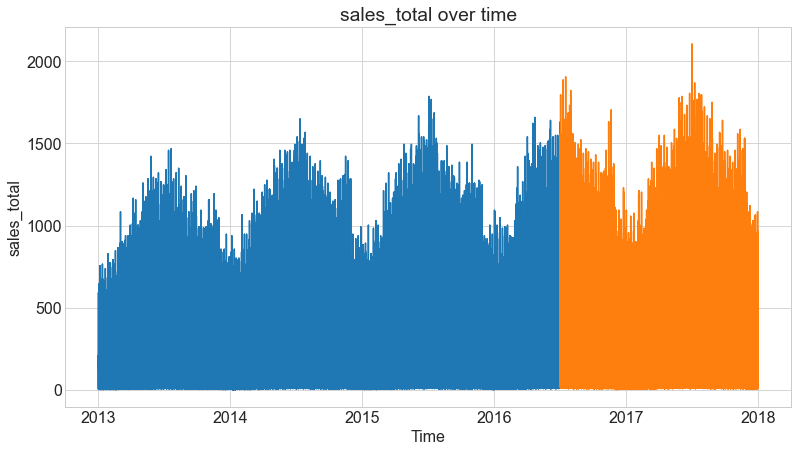

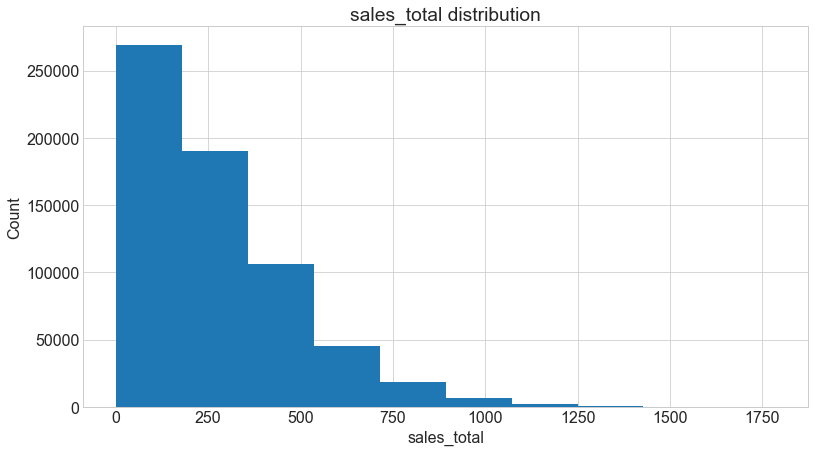

In [174]:
train0, test0, y_train0, y_test0 = explore_split_time_series(df0,target0)

(3068, 6) train shape


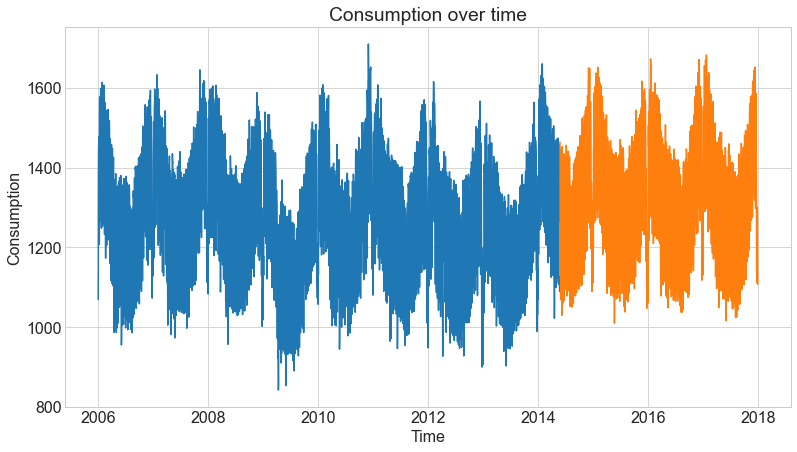

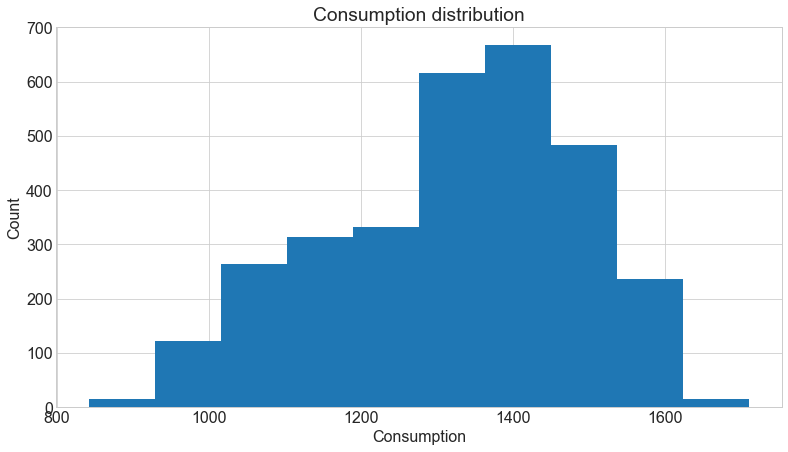

In [175]:
train1, test1, y_train1, y_test1 = explore_split_time_series(df1,target1)

In [176]:
def explore_target_mean_time_series(y_train,target):
    ''' 
    
    '''
    y_train.resample('D').mean().plot(alpha=.5, label='Daily')
    y_train.resample('W').mean().plot(alpha=.8, label='Weekly')
    y_train.resample('M').mean().plot(label='Montly')
    y_train.resample('Y').mean().plot(label='Yearly')
    plt.title(f"{target} over time")
    plt.legend()
    plt.show()


    y_train.groupby(y_train.index.day_name()).mean().\
        sort_values().plot.bar(width=.9, 
                               ec='black',
                               title=f'Average {target} by Weekday', 
                               xlabel='Weekday', 
                               ylabel=target)
    plt.xticks(rotation=0)

    ax = y_train.groupby(y_train.index.isocalendar().week).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Week', xlabel='Week', ylabel=target)
    plt.show()

    ax = y_train.groupby(y_train.index.month).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Month', xlabel='Month', ylabel=target)
    plt.show()

    ax = y_train.groupby(y_train.index.year).mean().plot.bar(width=.9, ec='black')
    plt.xticks(rotation=0)
    ax.set(title=f'Average {target} by Year', xlabel='Year', ylabel=target)
    plt.show()

    None

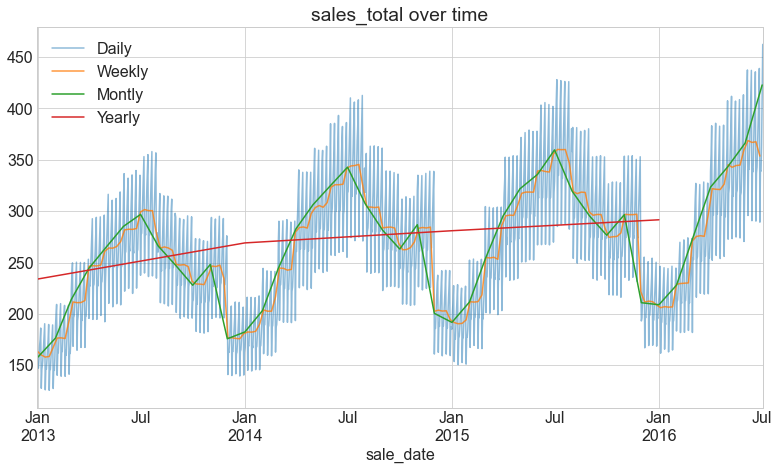

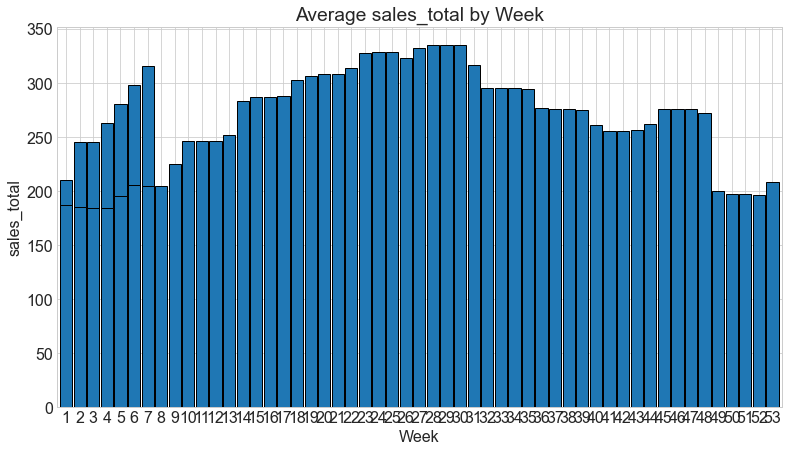

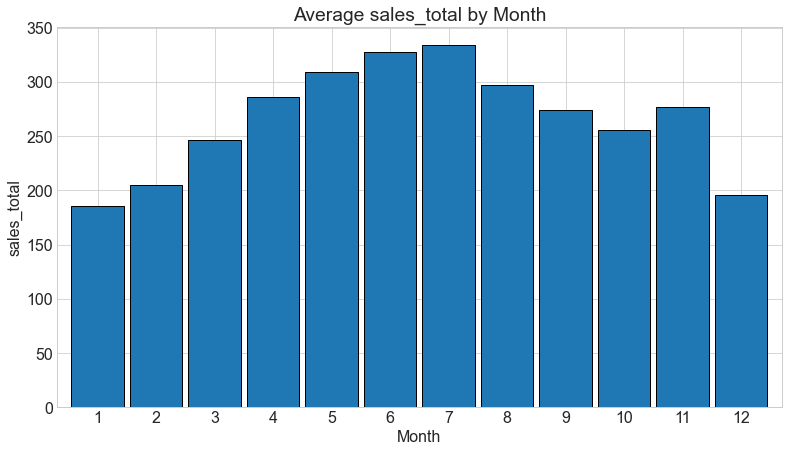

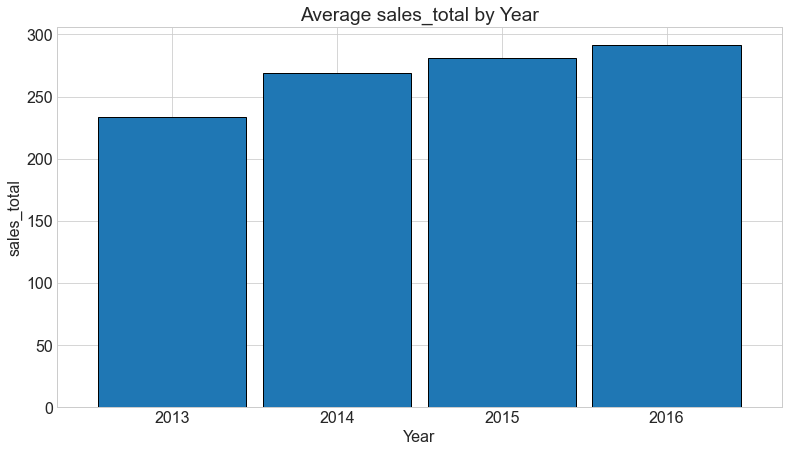

In [177]:
explore_target_mean_time_series(y_train0,target0)

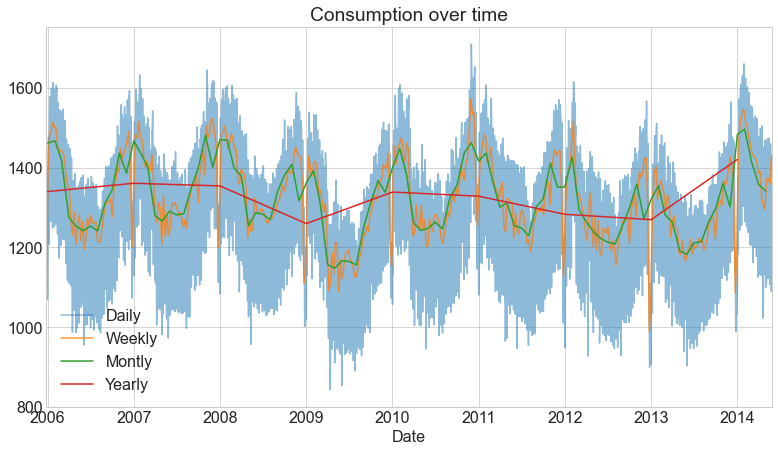

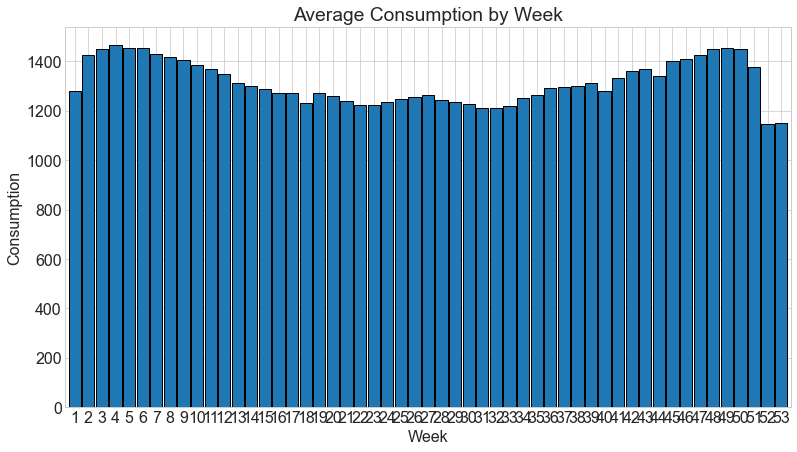

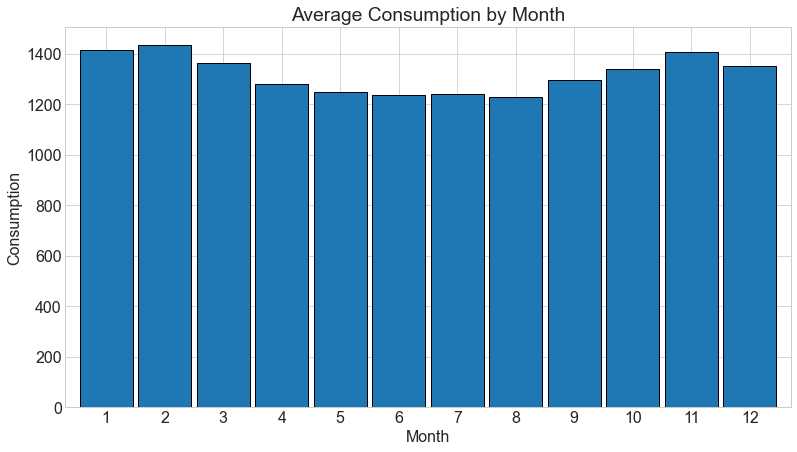

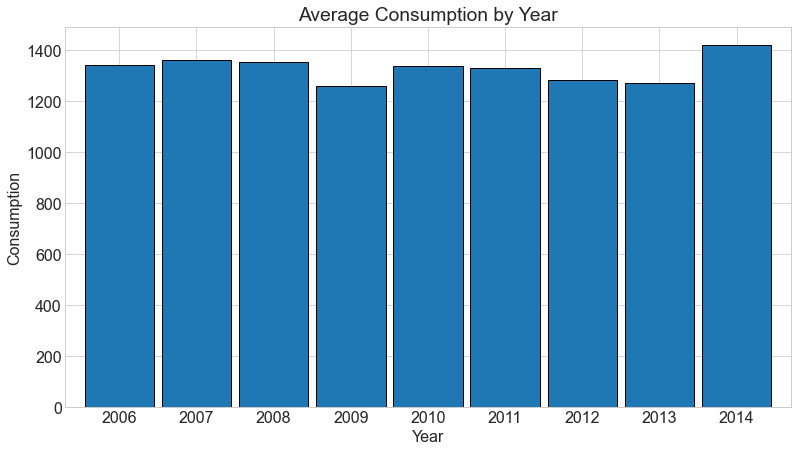

In [178]:
explore_target_mean_time_series(y_train1,target1)

In [188]:
def explore_target_diff_time_series(y_train,target):
    ''' 
    input y_train and target
    prints out a few plots with diffent time spacing
    '''

    y_train.resample('W').mean().diff().plot(title=f'Average change in {target}',label="Week to Week")
    y_train.resample('M').mean().diff().plot(title=f'Average change in {target}',label="Month to Month")
    y_train.resample('Y').mean().diff().plot(title=f'Average change in {target}',label="Year to Year")
    plt.xlabel("Time")
    plt.ylabel(f"{target}")
    plt.legend()

    y_train.groupby([y_train.index.year, y_train.index.month]).mean().unstack(0).plot(title='Seasonal Plot')
    table = y_train.groupby([y_train.index.year, y_train.index.month]).mean().unstack()

    fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
    for ax, (month, subset) in zip(axs, table.iteritems()):
        subset.plot(ax=ax, title=month)
        ax.hlines(subset.mean(), *ax.get_xlim())
        ax.set(xlabel='')

    fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
    fig.subplots_adjust(wspace=0)
    plt.show()
    None

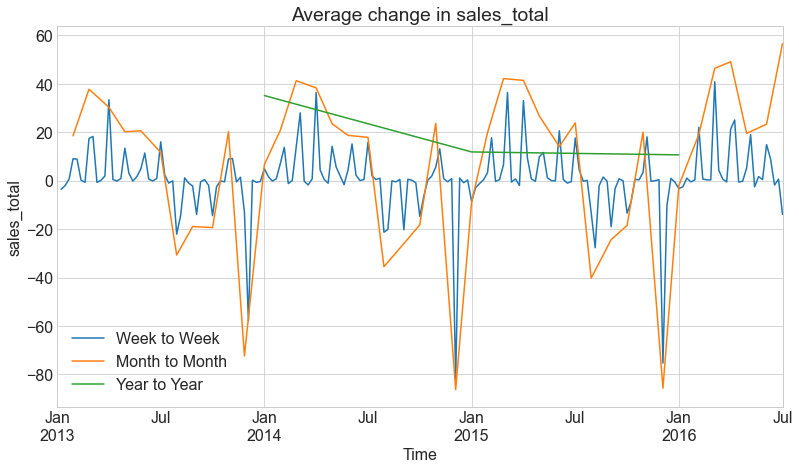

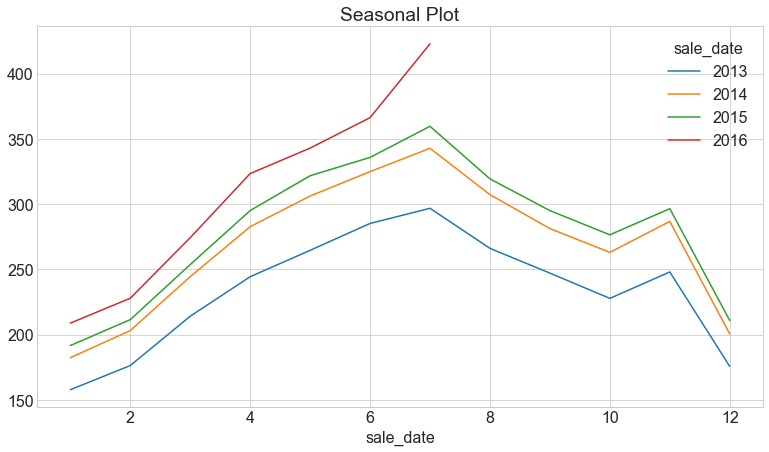

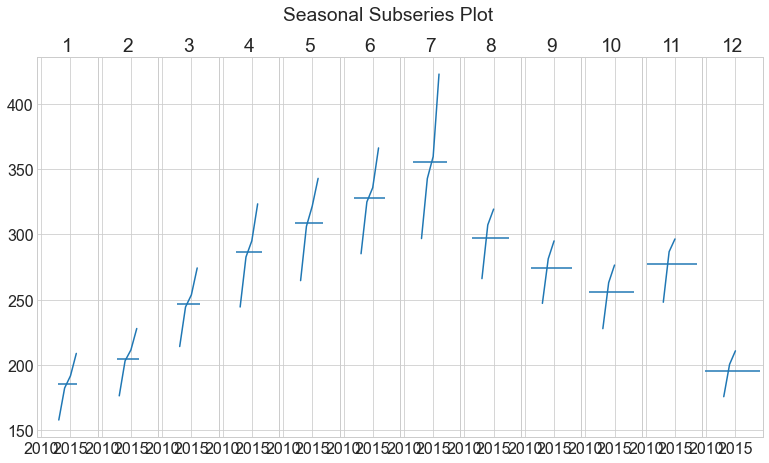

In [189]:
explore_target_diff_time_series(y_train0,target0)

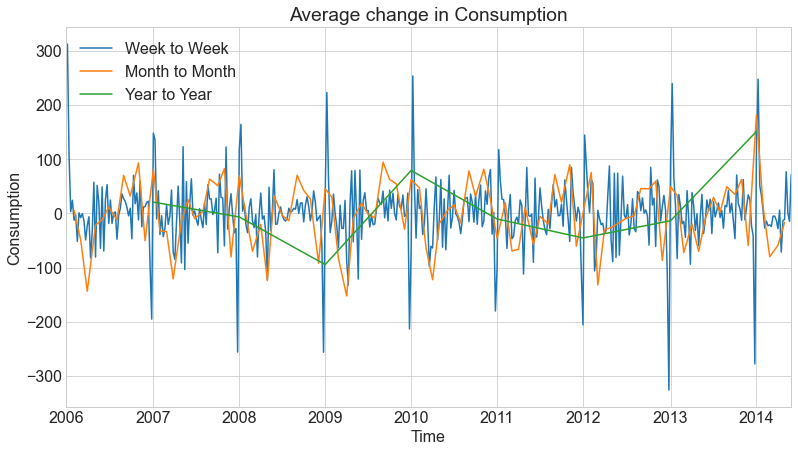

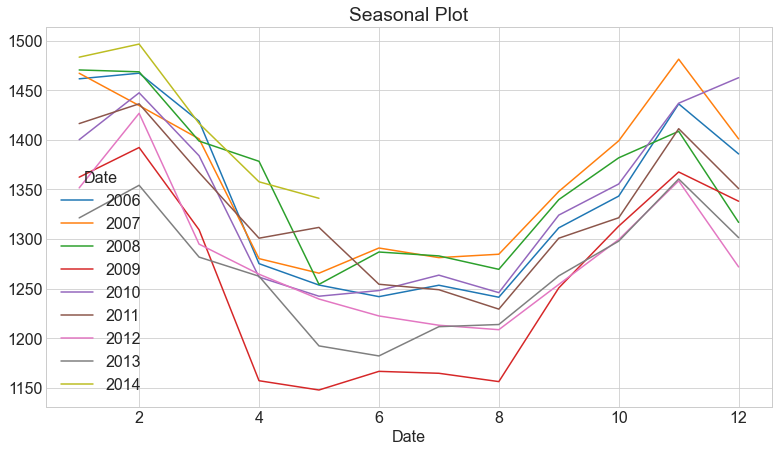

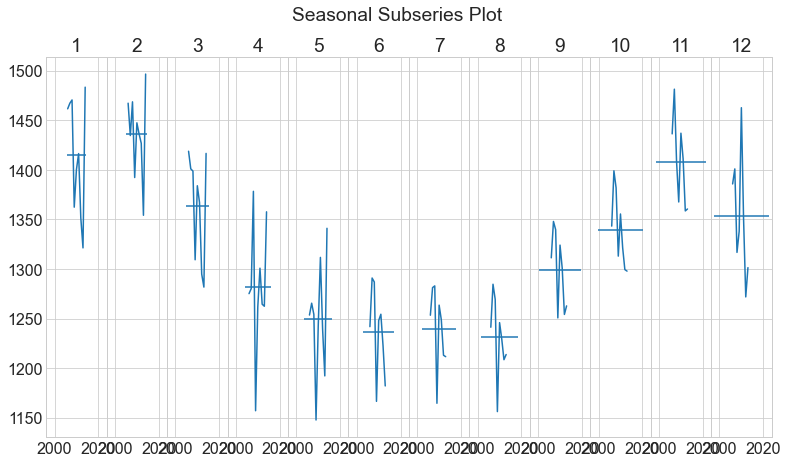

In [190]:
explore_target_diff_time_series(y_train1,target1)

,sale_amount,store,store_zipcode,item_price,this_week,the_next_week
sale_date,,,,,,
2013-01-06,30.355667,5.500000,78224.800000,5.160400,163.589167,159.981203
2013-01-13,29.686286,5.500000,78224.800000,5.160400,159.981203,157.946720
2013-01-20,29.414286,5.500000,78224.800000,5.160400,157.946720,158.545383
2013-01-27,29.513714,5.500000,78224.800000,5.160400,158.545383,167.585014
2013-02-03,31.150571,5.500000,78224.800000,5.160400,167.585014,176.455603
...,...,...,...,...,...,...
2016-06-05,67.033714,5.500000,78224.800000,5.160400,359.764591,368.762929
2016-06-12,68.506000,5.500000,78224.800000,5.160400,368.762929,366.946089
2016-06-19,68.261143,5.500000,78224.800000,5.160400,366.946089,367.585309


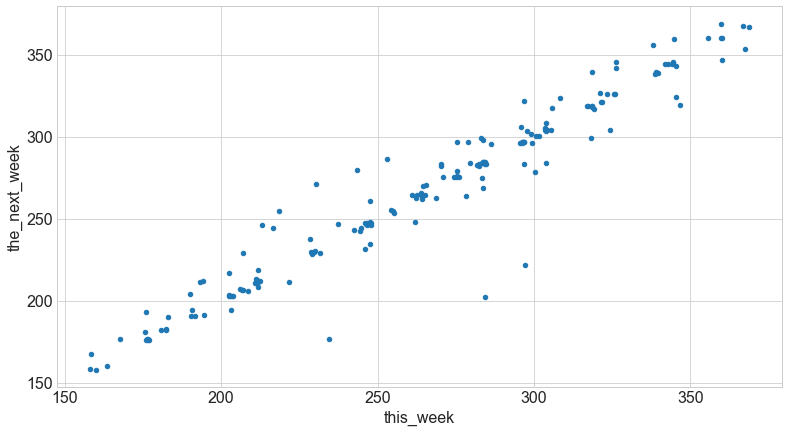

In [130]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.sales_total.shift(-1)
weekly = weekly.rename(columns={'sales_total': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

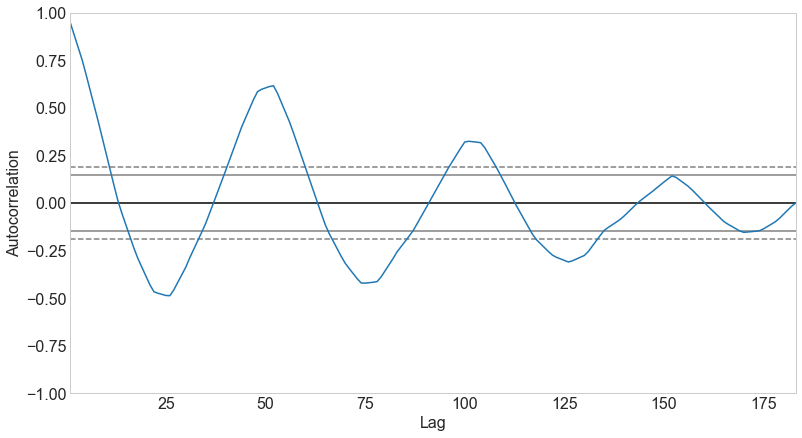

In [131]:
pd.plotting.autocorrelation_plot(train.sales_total.resample('W').mean())

,y,trend,seasonal,resid
sale_date,,,,
2013-01-06,163.589167,NaN,-77.817427,NaN
2013-01-13,159.981203,NaN,-76.420498,NaN
2013-01-20,157.946720,NaN,-77.661680,NaN
2013-01-27,158.545383,NaN,-77.653889,NaN
2013-02-03,167.585014,NaN,-73.077372,NaN


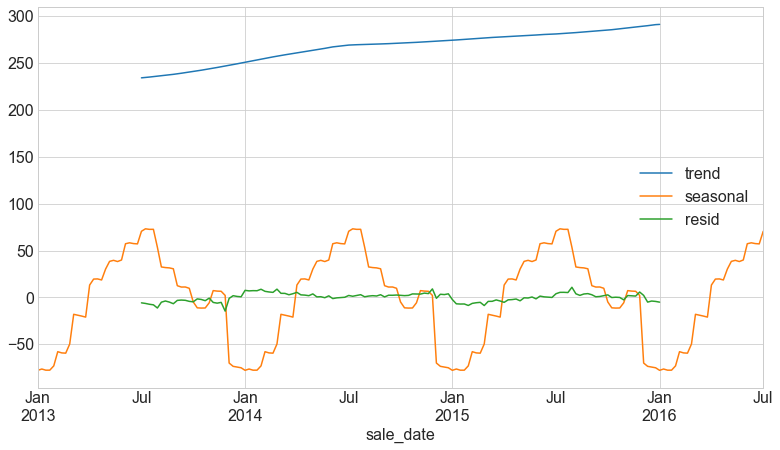

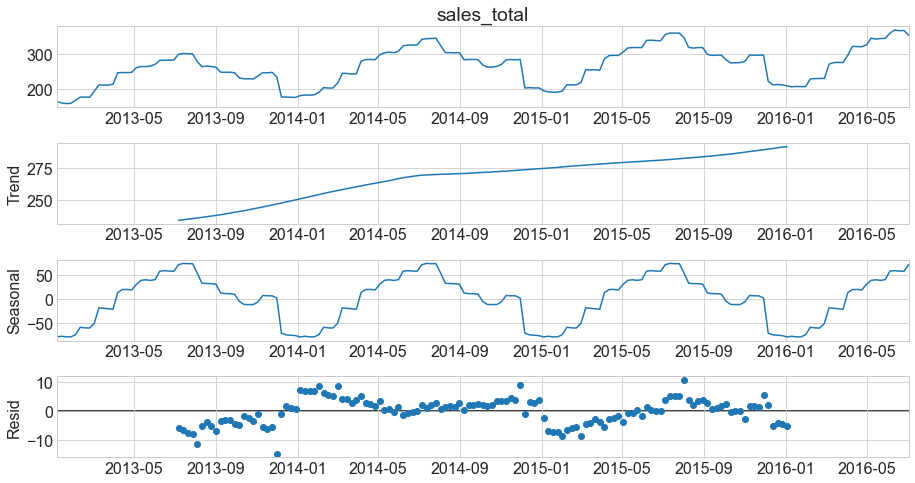

In [133]:
y_train = train.sales_total.resample('W').mean()

result = sm.tsa.seasonal_decompose(y_train)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.iloc[:, 1:].plot()
result.plot()
decomposition.head()

Text(0, 0.5, '% of days in the month')

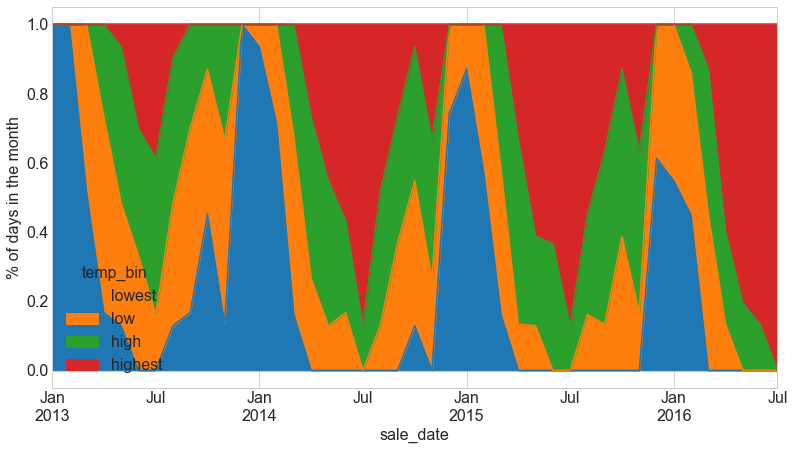

In [135]:
train = train.resample('D').mean()
# create a categorical feature
train['temp_bin'] = pd.qcut(train.sales_total, 4, labels=['lowest', 'low', 'high', 'highest'])
train.groupby('temp_bin').mean()

(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_25668/568318581.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ax = (train['2015']


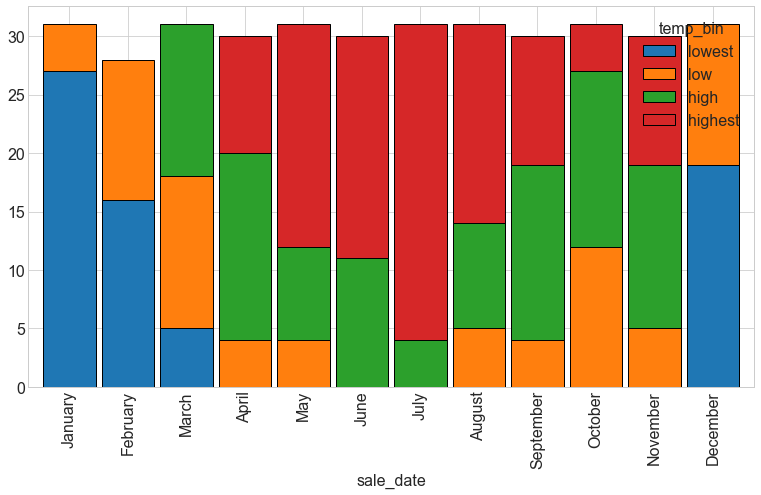

In [137]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)
None

AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

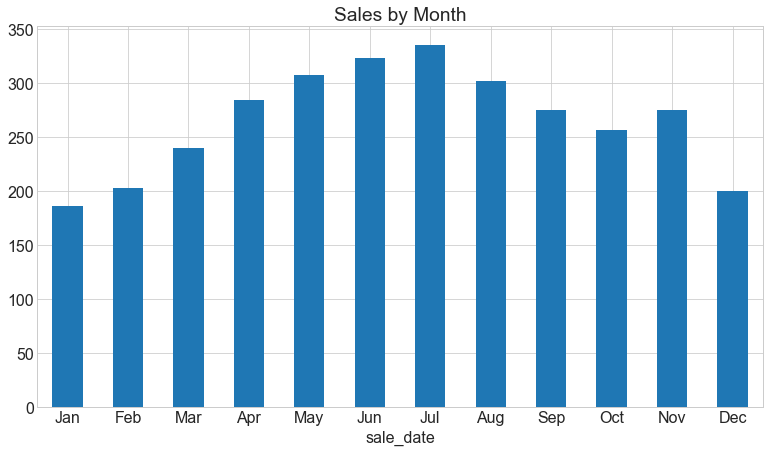

In [141]:
ax = y_train.groupby(y_train.index.strftime('%m-%b')).mean().plot.bar(title="Sales by Month")
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None